## Toward Handling Toxic and Divisive Content on Social Media

In [1]:
# Loading libraries

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.utils import resample
%matplotlib inline


Using TensorFlow backend.


## Pre-processing Dataset

In [2]:
# Loading training dataset

df=pd.read_csv('train.csv')

In [3]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
df.info()  # no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [5]:
# About 6% of the data has label 1

Counter(df['target'])

Counter({0: 1225312, 1: 80810})

In [6]:
stops=stopwords.words('english')+list(string.punctuation)

In [7]:
# Loading Glove vector

print('Loading word vectors...')
word2vec = {}
embedding = []
idx2word = []
with open('glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
print('Found %s word vectors.' % len(word2vec))
embedding = np.array(embedding)
V, D = embedding.shape
word2idx={word:index_no for index_no , word in enumerate(idx2word)}

Loading word vectors...
Found 400000 word vectors.


In [8]:
# Tokenize words in each row, remove stopwords and remove words not in Glove

df['clean_text']=df['question_text'].apply(lambda x:[t for t in word_tokenize(x.lower()) if (t not in stops) & (t in idx2word)] )

In [9]:
df.head()

,qid,question_text,target,clean_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,"[quebec, nationalists, see, province, nation, ..."
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"[adopted, dog, would, encourage, people, adopt..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"[velocity, affect, time, velocity, affect, spa..."
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"[otto, von, guericke, used, magdeburg, hemisph..."
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,"[convert, helicon, mountain, bike, changing, t..."


In [10]:
# Maximum size sentence

max(df.clean_text.apply(len))

78

In [11]:
# Word mapping to index in Glove

df['clean_text_idx']=df['clean_text'].apply(lambda x:[word2idx[t] for t in x] )

In [12]:
df.head()

,qid,question_text,target,clean_text,clean_text_idx
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,"[quebec, nationalists, see, province, nation, ...","[5074, 9186, 253, 624, 513, 2989]"
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"[adopted, dog, would, encourage, people, adopt...","[2181, 2926, 54, 3564, 69, 5045, 2855]"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"[velocity, affect, time, velocity, affect, spa...","[12190, 3194, 79, 12190, 3194, 863, 13780]"
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"[otto, von, guericke, used, magdeburg, hemisph...","[9639, 4145, 219309, 180, 36018, 53471]"
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,"[convert, helicon, mountain, bike, changing, t...","[7037, 136941, 1611, 7696, 2803, 21388]"


In [13]:
# Upsampling minority class

df_majority = df[df.target==0]
df_minority = df[df.target==1]
 
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1000000,    # to match majority class
                                 random_state=101) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.target.value_counts()

0    1225312
1    1000000
Name: target, dtype: int64

In [14]:
df_upsampled.head()

,qid,question_text,target,clean_text,clean_text_idx
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,"[quebec, nationalists, see, province, nation, ...","[5074, 9186, 253, 624, 513, 2989]"
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"[adopted, dog, would, encourage, people, adopt...","[2181, 2926, 54, 3564, 69, 5045, 2855]"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"[velocity, affect, time, velocity, affect, spa...","[12190, 3194, 79, 12190, 3194, 863, 13780]"
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"[otto, von, guericke, used, magdeburg, hemisph...","[9639, 4145, 219309, 180, 36018, 53471]"
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,"[convert, helicon, mountain, bike, changing, t...","[7037, 136941, 1611, 7696, 2803, 21388]"


In [15]:
# Pad all input to a fix size vector

data_pad=pad_sequences(df_upsampled['clean_text_idx'],maxlen=78)

In [16]:
data_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 5074, 9186,  253,  624,  513,
       2989])

In [17]:
data_pad.shape

(2225312, 78)

In [18]:
labels=df_upsampled['target']

In [19]:
# Convert labels to vector of size n x 2

labels=to_categorical(labels,num_classes=2)

## Wordcloud Exploration for Fun

In [20]:
df1=df[df['target']==1]['question_text']

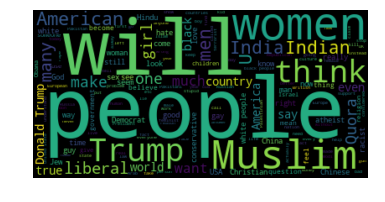

In [21]:
text=df1.str.cat(sep=' ')
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
df0=df[df['target']==0]['question_text']

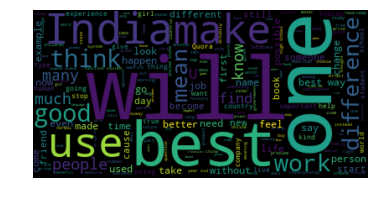

In [23]:
text0=df0.str.cat(sep=' ')
wordcloud = WordCloud().generate(text0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Model Creation

In [24]:
lstm_hidden_units=128  # no of hidden units 
num_classes=2
embedding_size=100  # embedding vector size
sentence_len=78  # max sentence length in dataset
vocab_size=400000  # Glove vocab size

In [30]:
def model():
    
    x=tf.placeholder(tf.int32,shape=[None,sentence_len])  # input place holder
    y=tf.placeholder(tf.float32,shape=[None,2]) # output place holder
    
    w=tf.Variable(tf.random_normal([lstm_hidden_units,num_classes]))
    b=tf.Variable(tf.constant(0.1,shape=[num_classes]))
        
    Embedding = tf.get_variable(name="word_embedding", shape=[embedding.shape[0],embedding_size],
                                                       initializer=tf.constant_initializer(embedding),
                                                       trainable=False) # loading embedding matrix                               
    embed_lookup=tf.nn.embedding_lookup(Embedding,x) # batch_size x sentence_length x embedding_size
    
    lstm_cell=tf.contrib.rnn.BasicLSTMCell(lstm_hidden_units) # create LSTM layer
    current_batch_size=tf.shape(x)[0]
    initial_state=lstm_cell.zero_state(current_batch_size,dtype=tf.float32) # state initialisations

    outputs, _ =tf.nn.dynamic_rnn(lstm_cell,embed_lookup,initial_state=initial_state,dtype=tf.float32)#batch_size x sen_length x hidden_units 
    outputs=tf.transpose(outputs,[1,0,2]) #sentence_length x batch_size x hidden_units
    last=tf.gather(outputs,int(outputs.get_shape()[0])-1)  # # batch_size x hidden_units
    
    predictions=tf.matmul(last,w)+b # batch_size x 2
    correct_predictions=tf.equal(tf.argmax(tf.nn.sigmoid(predictions),axis=1),tf.argmax(y,axis=1))
    accuracy=tf.reduce_mean(tf.cast(correct_predictions,tf.float32))     
    loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions,labels=y))
    optimizer=tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)
    
    return optimizer,loss,x,y,accuracy,predictions, correct_predictions
    

## Training and Testing

In [26]:
X_train,X_test, y_train,y_test=train_test_split(data_pad,labels,test_size=0.3,random_state=101)

In [27]:
X_train.shape

(1557718, 78)

In [28]:
X_test.shape

(667594, 78)

In [31]:
tf.reset_default_graph()
optimizer,loss,x,y,accuracy,predictions, correct_predictions=model()

C:\Users\fatah\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [32]:
batch_size=32
num_batches=len(X_train)//batch_size

In [34]:
with tf.Session() as sesh:
    
    init=tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sesh.run(init)    
    saver = tf.train.Saver()
    writer= tf.summary.FileWriter("logdir/", graph = sesh.graph)    
    test_accuracy=[]   
    
    for i in range(num_batches):
        if i !=num_batches-1:
            x_batch=X_train[i*batch_size:i*batch_size+batch_size]
            y_batch=y_train[i*batch_size:i*batch_size+batch_size]
        else:
            x_batch=X_train[i*batch_size:]
            y_batch=y_train[i*batch_size:]
        
        _, l, a=sesh.run([optimizer,loss,accuracy],feed_dict={x:x_batch,y:y_batch})
            
        if i>0 and i % 500==0:
            # Randomly setting testing data to see performance when training
            rand_idx = np.random.choice(np.arange(len(X_test)),200, replace=False)
            test_x = X_test[rand_idx]
            test_y = y_test[rand_idx]
            
            t_l, t_a=sesh.run([loss,accuracy],feed_dict={x:test_x,y:test_y})
            test_accuracy.append(t_a)
            print("Step",i,"of", num_batches,"loss",l,"accuracy",a)
            print("Test loss", t_l,"accuracy",t_a)            
        
    print("Average accuracy", np.mean(test_accuracy))
    saver.save(sesh, "logdir\\lstm_model.ckpt")
    writer.flush()
    writer.close()
            

Step 500 of 48678 loss 0.306552 accuracy 0.90625
Test loss 0.421432 accuracy 0.795
Step 1000 of 48678 loss 0.396838 accuracy 0.78125
Test loss 0.332989 accuracy 0.855
Step 1500 of 48678 loss 0.532871 accuracy 0.71875
Test loss 0.34287 accuracy 0.865
Step 2000 of 48678 loss 0.273426 accuracy 0.90625
Test loss 0.33279 accuracy 0.865
Step 2500 of 48678 loss 0.170967 accuracy 0.9375
Test loss 0.313362 accuracy 0.865
Step 3000 of 48678 loss 0.197062 accuracy 0.90625
Test loss 0.273566 accuracy 0.9
Step 3500 of 48678 loss 0.171502 accuracy 0.96875
Test loss 0.270069 accuracy 0.89
Step 4000 of 48678 loss 0.233579 accuracy 0.90625
Test loss 0.320106 accuracy 0.86
Step 4500 of 48678 loss 0.25989 accuracy 0.875
Test loss 0.26426 accuracy 0.9
Step 5000 of 48678 loss 0.392177 accuracy 0.84375
Test loss 0.309422 accuracy 0.88
Step 5500 of 48678 loss 0.290632 accuracy 0.875
Test loss 0.330098 accuracy 0.865
Step 6000 of 48678 loss 0.266149 accuracy 0.90625
Test loss 0.273478 accuracy 0.875
Step 6500